In [37]:
 from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [38]:
%%capture
!pip install ffmpeg

In [ ]:
%%capture
!unzip "/content/gdrive/My Drive/EmotiW_2018.zip"

In [ ]:
%%capture
# !unzip "/content/gdrive/MyDrive/TFM_MUSI/Audio_Speech_Actors_01-24.zip"

In [ ]:
import ffmpeg
import glob, os,shutil

import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy import save
from numpy.random import seed

import librosa                    
import librosa.display
import IPython.display as ipd
import scipy.io.wavfile
from scipy.fftpack import dct
from scipy import signal

import operator
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D
from keras import applications
from keras.models import load_model
from keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,CSVLogger
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil

import csv
from csv import DictWriter
from datetime import datetime
from packaging import version
from pathlib import Path

In [ ]:
#Set seed
seed(42)
tf.random.set_seed(42)

In [ ]:
dict_xy_afew={}
train_set_path='EmotiW_2018/Train_AFEW/'
test_set_path='EmotiW_2018/Val_AFEW/'

os.remove(train_set_path+'Train_6.xml')
os.remove(train_set_path+'AlignedFaces_LBPTOP_Points.zip')
os.remove(test_set_path+'Val_6.xml')
os.remove(test_set_path+'AlignedFaces_LBPTOP_Points_Val.zip')

emotions=sorted(os.listdir(train_set_path))
print(emotions)

In [ ]:
num_emotions=7
emo_dict={}
for emo,i in zip(emotions, range(num_emotions+1)):
  emo_dict[emo]=i
print(emo_dict)

emo_dict_reversed = {v: k for k, v in emo_dict.items()}
print(emo_dict_reversed)

In [ ]:
#Convert a video set into audio format
def convert_to_audio_ne(set_path,set_name):
  f = open("convert_to_audio.sh", "w")
  path_afew_set=set_path
  urls_afew = glob.glob(pathname=path_afew_set + '*')
  print(urls_afew)
  print("-------------------")
  for url_emo in urls_afew:
    urls_emotion = glob.glob(pathname=url_emo + '/*')
    # print(urls_emotion)
    emo=os.path.basename(url_emo)
    new_dir=set_name+'_audio_ne/'
    if not os.path.exists(set_name+'_audio_ne'):
      os.makedirs(set_name+'_audio_ne')
    print(emo)
    for video_file in urls_emotion:
      file_name=os.path.splitext(os.path.basename(video_file))
      f.write("ffmpeg -i "+video_file+" -vn -ac 1 "+new_dir+file_name[0]+".wav"+'\n')
      dict_xy_afew[file_name[0]]=emo
  f.close()

In [ ]:
%%capture
#Extract audio from the videos
!rm -rf Train_audio_ne
convert_to_audio_ne(train_set_path,'Train')
! bash convert_to_audio.sh
!rm -rf Test_audio_ne
convert_to_audio_ne(test_set_path,'Test')
! bash convert_to_audio.sh

In [ ]:
train_path='Train_audio_ne/'
test_path='Test_audio_ne/'

urls_afew_train = glob.glob(pathname=train_path + '*')
urls_afew_test = glob.glob(pathname=test_path + '*')
urls_afew_test[0]

In [ ]:
print("number of train samples:",len(urls_afew_train))
print("number of test samples:",len(urls_afew_test))

In [ ]:
emotions=[]
num_samples=[]
for emo in emo_dict.keys():
  samples=list(dict_xy_afew.values()).count(emo)
  num_samples.append(samples)
  emotions.append(emo)
  print("emotion: ", emo)
  print("number of audios: ",samples)
  print("-----")

#Está desbalanceado. Graficamos la distribución por clases:

fig = plt.figure(figsize = (10, 5))
plt.bar(emotions, num_samples, 
        0.35,label="number of samples",color ='blue')
plt.xlabel("emotion classes")
plt.ylabel("No. of samples")
plt.title("Number of samples per emotion in the AFEW dataset")
plt.show()

In [ ]:
def get_categorical_label(file_id):
  emo=dict_xy_afew[file_id]
  categorical_label=tf.keras.utils.to_categorical(emo_dict[emo], num_classes=num_classes)
  return categorical_label

def get_emo_label(categorical_label):
  emo=dict_xy_afew[file_id]
  return emo

def get_emo_from_categorical(label):
  idx=list(label).index(1)
  return emo_dict_reversed[idx]

def plot_model(history,title):
  fig=plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title("model train and val accuracy "+title)
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)
  plt.show()

def save_plot(history,title,filename="/content/gdrive/My Drive/TFM_MUSI/Audio/Results/"):
  fig = plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title("model train and val accuracy "+title)
  plt.show()
  new_filename  = Path(filename +'/'+title+'.jpg')
  fig.savefig(new_filename, dpi=400, bbox_inches='tight',pad_inches=0)

def plot_conf_matrix(test_set,modelo,path,title,standard_format=True,percentages=True,save_plot=True):
  y_true=test_set.labels
  print(len(y_true))
  labels=[key for key in test_set.class_indices.keys()]
  predictions=modelo.predict(test_set)
  ypred=[round(list(i).index(max(i))) for i in predictions]
  print(confusion_matrix(test_set.classes, ypred)[:,:])
  print("")
  f1=f1_score(y_true, ypred,average=None)
  f1_w=f1_score(y_true, ypred,average='weighted')
  ac=accuracy_score(y_true, ypred)
  print("accuracy: ",ac)
  print("f1 score:",f1)
  print("f1 score weighted:",f1_w)
  print("---------------------------------------------------------")
  print(title)
  if standard_format:
    cm = confusion_matrix(y_true, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='d')
    if save_plot:
      plt.savefig(path+".png")
    plt.show()
  print("")
  if percentages:
    cm = confusion_matrix(y_true, ypred,normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='.2f')
    plt.show()
    if save_plot:
      plt.savefig(path+"_perctg.png")
    plt.show()
  print("")

In [ ]:
# get len min of audio sets
urls=urls_afew_train[:]
urls.extend(urls_afew_test)
audios_len=[]
max=0
for audio_sample in urls:
  # print(urls_afew_train)
  audio,sr = librosa.load(audio_sample,sr=22050)
  audios_len.append(audio.shape[0])
  if audio.shape[0]>max:
    max=audio.shape[0]
    print("new max",max)
    print(audio_sample)
    print("----------------")

In [ ]:
print("maximum audio length: ", np.max(audios_len), "is from audio:",urls[audios_len.index(np.max(audios_len))] )
print("minimum audio length: ",np.min(audios_len), "is from audio:",urls[audios_len.index(np.min(audios_len))])
print("mean audio length : ",np.mean(audios_len))

In [ ]:
#Analizamos como son el audio más corto y más largo del dataset:

In [ ]:
#Audio más corto
audio,sr = librosa.load("Train_audio_ne/011603980.wav")
librosa.get_duration(audio)
librosa.display.waveplot(audio)
print(librosa.get_duration(audio))
print(sr)
ipd.Audio("Train_audio_ne/011603980.wav")

In [ ]:
#Audio más largo:
len(urls)
print(urls[934])
audio,sr = librosa.load("Test_audio_ne/003353294.wav")
librosa.display.waveplot(audio, sr=sr)
print(librosa.get_duration(audio))
audio.shape[0]
print(sr)
ipd.Audio("Test_audio_ne/003353294.wav")

Test_audio_ne/010904207.wav
5.328027210884354
22050


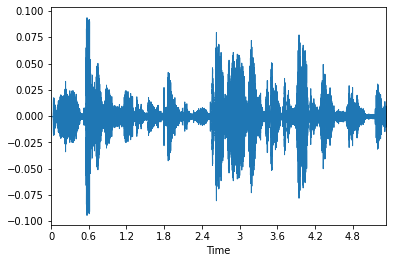

In [29]:
#Audio más largo del set de entrenamiento
len(urls)
print(urls[934])
audio,sr = librosa.load("Train_audio_ne/003853320.wav")
librosa.display.waveplot(audio, sr=sr)
print(librosa.get_duration(audio))
audio.shape[0]
print(sr)
ipd.Audio("Train_audio_ne/003853320.wav")

In [32]:
#resize audios to a new standard size shortening or padding with zeros
def standarize_audios_len(audio_file,desired_len):
  len=asarray(audio_file).shape
  # print(len)
  # print("dif=", abs(len[0]-desired_len))
  if len[0] < desired_len:
    # print("short")
    zeros=np.zeros(abs(len[0]-desired_len))
    new_audio=np.append(audio_file,zeros)
  else:
    new_audio=audio_file[0:desired_len]
  
  return new_audio

In [36]:
#function to preprocess audio:
# standarizes the audio lenght to the maximum audio len padding with 0s so all audios have the same dimensions
# Applies a preemphasis filter if set
# Computes de log-mel-spectrogram and normalizes it if set

def preprocess_audio(audio_file, desired_audio_len=137063, frame_size=0.025, stride=0.01,normalize=False,preemphasis=True,norm_waveform=False):
  #normalize waveform
  if norm_waveform:
    audio_file = (audio_file - audio_file.mean()) / audio_file.std() + 1e-10

  y,sr = librosa.load(audio_file) 
  # shortened_audio=y[0:8997]
  y=standarize_audios_len(y,desired_audio_len) #standarize the len of the audios padding with 0s:

  if preemphasis==True: 
    y=librosa.effects.preemphasis(y, coef=0.97) #Apply a pre-emphasis filter

  #frame size mejor potencia de 2?  
  frame_size=int(round(frame_size*sr)) #frame_size en samples dim
  stride_size= int(round(stride*sr))  #stride_size en samples dim
  mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_fft=frame_size,window=scipy.signal.hamming, hop_length=stride_size, n_mels=40)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  
  if normalize==True:
    mean = np.mean(log_mel_spectrogram, axis=0)
    std = np.std(log_mel_spectrogram, axis=0)
    log_mel_spectrogram = (log_mel_spectrogram - mean) / std + 1e-10

  return log_mel_spectrogram,sr

In [35]:
def create_set(url_list, dict_set, desired_audio_len=137063, normalize=False, preemphasis=True):
  x_data,y_data=[],[]
  mean=[]
  spec_values=[]
  i=0
  for audio_file in url_list:
    file_id=os.path.splitext(os.path.basename(audio_file))[0]
    melSpec_dB,sr = preprocess_audio(audio_file,desired_audio_len=137063, frame_size=0.025, stride=0.01,normalize=normalize,preemphasis=preemphasis)
    mean.extend(np.mean(melSpec_dB,axis=0))
    spec_values.extend(melSpec_dB)
    
    #   #check
    #   plt.figure(figsize=(10, 5))
    #   librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    #   plt.colorbar(format='%+1.0f dB')
    #   plt.title("MelSpectrogram")
    #   plt.tight_layout()
    #   plt.show()

    label=get_categorical_label(file_id)
    dict_set[audio_file]=label
    x_data.append(melSpec_dB)
    y_data.append(label)
  return x_data,y_data,mean,spec_values


In [ ]:
normalize=False # alerta amb Nans
preemphasis=True
desired_audio_len=137063 #maximum len
num_classes=7

train_data={}
test_data={}

x_data_train,y_data_train,mean,spec_values = create_set(urls_afew_train, train_data, desired_audio_len ,normalize,preemphasis)

KeyError: ignored

In [ ]:
x_data_test,y_data_test,_,_ = create_set(urls_afew_test,test_data, desired_audio_len, normalize,preemphasis)

In [ ]:
spec_values

In [ ]:
spec_vals=asarray(spec_values).flatten()
train_mean=np.mean(spec_vals)
train_std=np.std(spec_vals)
# spec_values.flatten()
print(train_mean)
print(train_std)

-80.70755563843169
22.2797843560173


In [ ]:
#normalitzar per frequency band
new_data_train=[]
for spec in x_data_train:
  norm_spec=(spec-train_mean)/train_std+1e-10
  new_data_train.append(norm_spec)

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(new_data_train, y_data_train, test_size=0.20, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
train_labels=[get_emo_from_categorical(label) for label in y_train]
# train_labels

NameError: ignored

In [ ]:
list(emo_dict.keys())

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
           'balanced',
            list(emo_dict.keys()), 
            train_labels)
class_weights
indices=[0,1,2,3,4,5,6]
class_weight_dict=dict(zip(indices,class_weights))
class_weight_dict

{0: 0.8408163265306122,
 1: 1.4473067915690867,
 2: 1.279503105590062,
 3: 0.7357142857142858,
 4: 0.8251001335113485,
 5: 0.9493087557603687,
 6: 1.401360544217687}

In [ ]:
new_data_train=[]
for spec in x_data_train:
  norm_spec=(spec-train_mean)/train_std+1e-10
  new_data_train.append(norm_spec)

In [ ]:
new_data_test=[]
for spec in x_data_test:
  norm_spec=(spec-train_mean)/train_std+1e-10
  new_data_test.append(norm_spec)

In [ ]:
print(asarray(new_data_train).shape)
asarray(y_data_train).shape

(773, 40, 624)


(773, 7)

In [ ]:
print(asarray(new_data_test).shape)
asarray(y_data_test).shape

(381, 40, 624)


(381, 7)

In [ ]:
new_data_train[-1]

array([[-0.67131459, -0.67131459,  0.12119899, ..., -0.67131459,
        -0.67131459, -0.67131459],
       [-0.67131459, -0.67131459,  0.75075965, ..., -0.67131459,
        -0.67131459, -0.67131459],
       [-0.67131459, -0.67131459,  1.09354827, ..., -0.67131459,
        -0.67131459, -0.67131459],
       ...,
       [-0.66829813, -0.10636446,  1.4975113 , ..., -0.67131459,
        -0.67131459, -0.67131459],
       [-0.53587206,  0.01449921,  1.59042267, ..., -0.67131459,
        -0.67131459, -0.67131459],
       [-0.64602179, -0.0998281 ,  1.40000354, ..., -0.67131459,
        -0.67131459, -0.67131459]])

In [ ]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(new_data_train,y_data_train)
x_test,y_test=shuffle(new_data_test,y_data_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
print(asarray(X_train).shape)
print(asarray(y_train).shape)
print(asarray(x_data_train).shape)
print(asarray(X_val).shape)
x_train[-1]

(618, 40, 624)
(618, 7)
(773, 40, 624)
(155, 40, 624)


array([[-0.85924903, -0.85924903,  0.14738448, ..., -0.85924903,
        -0.85924903, -0.85924903],
       [-0.85924903, -0.85924903,  0.40581917, ..., -0.85924903,
        -0.85924903, -0.85924903],
       [-0.85924903, -0.85924903,  0.38113154, ..., -0.85924903,
        -0.85924903, -0.85924903],
       ...,
       [-0.81229913, -0.23445259,  0.34011358, ..., -0.85924903,
        -0.85924903, -0.85924903],
       [-0.83186218, -0.33521581,  0.18347238, ..., -0.85924903,
        -0.85924903, -0.85924903],
       [-0.85924903, -0.44743524, -0.1152997 , ..., -0.85924903,
        -0.85924903, -0.85924903]])

In [ ]:
#PARAMS:
DROPOUT=0.5
l2_regul=0.01
N_OUTPUT_LABELS=7
input_shape=asarray(x_data_train[0]).shape
input_shape=list(input_shape)
input_shape.append(1)
input_shape
epochs=50
batch_size=16
lr=0.0001

NameError: ignored

In [ ]:
input_shape=[40, 624, 1]

In [ ]:
input_shape

[40, 624, 1]

In [ ]:
def Classifier():
    model = Sequential()

    model.add(Conv2D(filters=16,
                     kernel_size=(10, 10),
                     strides=1,
                     activation='relu',
                     input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_regul)))
    
    model.add(BatchNormalization())
    # model.add(Dropout(DROPOUT))


    model.add(Conv2D(filters=32,
                     kernel_size=(10, 10),
                     strides=1,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_regul)))
    
   
    model.add(BatchNormalization())
    # model.add(Dropout(DROPOUT))

    #Afegit això:
    # model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    
    model.add(Dense(units=716,activation='relu'))
    
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='softmax'))


    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dense(units=N_OUTPUT_LABELS,
                    activation='softmax'))
    return model


audio_model = Classifier()


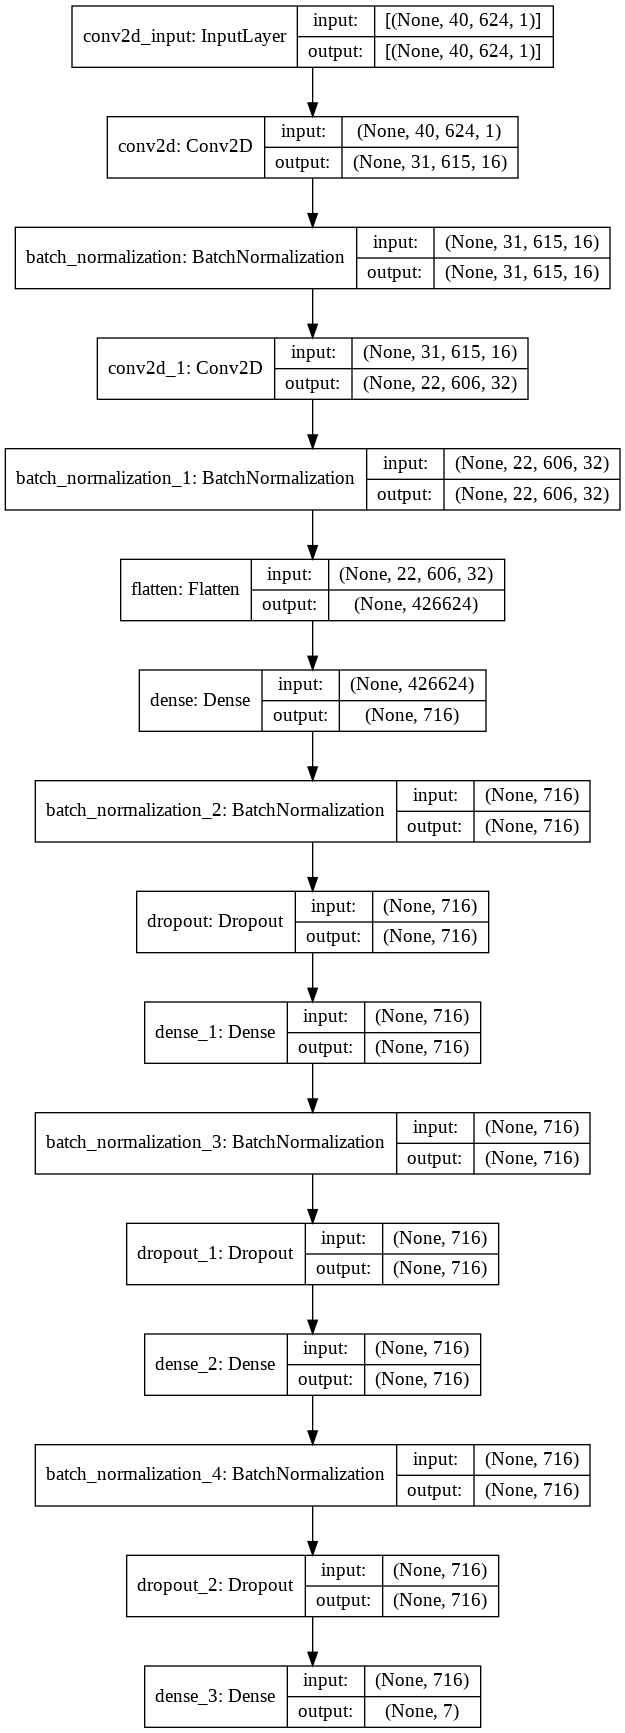

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(audio_model,to_file='audio_model1_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
audio_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 615, 16)       1616      
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 615, 16)       64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 606, 32)       51232     
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 606, 32)       128       
_________________________________________________________________
flatten (Flatten)            (None, 426624)            0         
_________________________________________________________________
dense (Dense)                (None, 716)               305463500 
_________________________________________________________________
batch_normalization_2 (Batch (None, 716)               2

In [ ]:
def compile_and_fit(model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=0.001):
  optimizer = tf.keras.optimizers.RMSprop(lr=lr)
  model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
  
  logdir = chkpoint_filepath + "corrected_test"
  
  if not os.path.exists(logdir):
      os.mkdir(logdir)
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
  
  # filepath="/content/gdrive/My Drive/TFM_MUSI/FACES6/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
  chkpoint_filepath=chkpoint_filepath+":{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
  checkpoint = ModelCheckpoint(chkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  
  # csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
  csv_logger = CSVLogger(csv_log_file)
  
  E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=30,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=False)

  # callbacks_list = [checkpoint,csv_logger]
  callbacks_list = [E_stopping]
  # callback_list = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=35)
  # history=model.fit(xtrain, Y_train,
  #                  epochs=epochs,
  #                  validation_data=(xtest, Y_test),
  #                  batch_size=batch_size,
  #                  class_weight=class_weight_dict,
  #                  callbacks=callback_list)

  history=model.fit(xtrain, y_train_new,
                   epochs=epochs,
                   validation_data=(xval, y_val_new),
                   batch_size=batch_size,
                  #  class_weight=class_weight_dict,
                   callbacks=callbacks_list)

  return history,model


In [ ]:
def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy "+title)
  # plt.show()
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.figure()
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title("Validation categorical accuracy"+title)

In [ ]:
# def training_loop(title, chkpoint_filepath, csv_log_file, epochs, batch_size, lr=0.01):
#   audio_model = Classifier()
#   history,model=compile_and_fit(audio_model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=0.01)
#   model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba2/prueba2.h5")
#   plot_model(history,title)
#   return history

In [ ]:
# ! mkdir "/content/gdrive/My Drive/TFM_MUSI/"

X_train_new=asarray(X_train)
y_train_new=asarray(y_train)
X_val_new=asarray(X_val)
y_val_new=asarray(y_val)
xtrain = tf.expand_dims(X_train_new, axis=-1)
xval= tf.expand_dims(X_val_new, axis=-1)

mkdir: cannot create directory ‘/content/gdrive/My Drive/TFM_MUSI/’: File exists


In [ ]:
print(xtrain.shape)
print(y_val_new.shape)
print(xval.shape)
print(y_train_new.shape)

(618, 40, 624, 1)
(155, 7)
(155, 40, 624, 1)
(618, 7)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
39/39 [==============================] - 56s 189ms/step - loss: 2.1740 - categorical_accuracy: 0.1716 - accuracy: 0.1716 - val_loss: 2.1696 - val_categorical_accuracy: 0.1613 - val_accuracy: 0.1613
Epoch 2/50
39/39 [==============================] - 6s 156ms/step - loss: 2.1521 - categorical_accuracy: 0.1880 - accuracy: 0.1880 - val_loss: 2.1636 - val_categorical_accuracy: 0.1613 - val_accuracy: 0.1613
Epoch 3/50
39/39 [==============================] - 6s 156ms/step - loss: 2.1538 - categorical_accuracy: 0.1861 - accuracy: 0.1861 - val_loss: 2.1570 - val_categorical_accuracy: 0.1613 - val_accuracy: 0.1613
Epoch 4/50
39/39 [==============================] - 6s 156ms/step - loss: 2.1210 - categorical_accuracy: 0.2586 - accuracy: 0.2586 - val_loss: 2.1496 - val_categorical_accuracy: 0.1613 - val_accuracy: 0.1613
Epoch 5/50
39/39 [==============================] - 6s 156ms/step - loss: 2.1288 - categorical_accuracy: 0.2551 - accuracy: 0.2551 - val_loss: 2.1413 - val_categorical

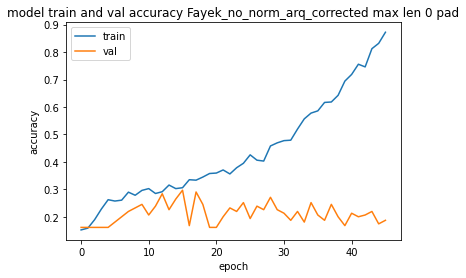

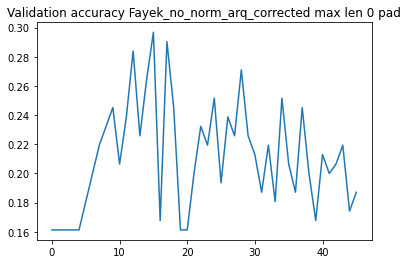

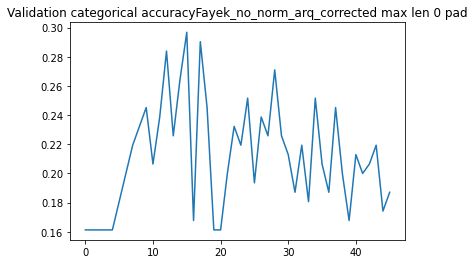

In [ ]:
#Test 1: Longitud de los audios= la longitud del audio más corto
# Sin pre-emphasis
# Sin normalizar


chkpoint_filepath="/content/gdrive/My Drive/TFM_MUSI"
csv_log_file='/content/gdrive/My Drive/TFM_MUSI/train_P4v2_audio.log'


# X_train=asarray(x_train)
# Y_train=asarray(y_train)
# X_test=asarray(x_test)
# Y_test=asarray(y_test)
# xtrain = tf.expand_dims(X_train, axis=-1)
# xtest= tf.expand_dims(X_test, axis=-1)

# print(xtrain.shape)
# X_train_=asarray(X_train)
# y_train_=asarray(y_train)
# X_val_=asarray(X_val)
# y_val_=asarray(y_val)
# xtrain = tf.expand_dims(X_train_, axis=-1)
# xval= tf.expand_dims(X_val_, axis=-1)


audio_model = Classifier()
history,model=compile_and_fit(audio_model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)
model.save("/content/gdrive/My Drive/TFM_MUSI/Fayek_no_norm_arq_corrected.h5")
plot_model(history,"Fayek_no_norm_arq_corrected max len 0 pad")

In [ ]:
#Va mal

In [ ]:
def save_plot(history,title,filename):
  fig = plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title("model train and val accuracy "+title)
  plt.show()
  new_filename  = Path(filename +'/'+title+'.jpg')
  fig.savefig(new_filename, dpi=400, bbox_inches='tight',pad_inches=0)

In [ ]:
save_plot(history,"P4v2 Fayek spec no normalized",filename="/content/gdrive/My Drive/TFM_MUSI/Audio/Results")

In [ ]:
#PARAMS:
params={}
params["num_prueba"]="P4v2 Fayek con espectrogramas"
params["description"]="longitud maxima"
params["DROPOUT"]=DROPOUT
params["l2_regul"]=l2_regul
params["learning rate"]=lr
params["N_OUTPUT_LABELS"]=N_OUTPUT_LABELS
params["batch_size"]=batch_size
params["epochs"]=epochs
params["desired_audio_len"]=desired_audio_len
params["preemphasis"]=preemphasis
params["normalize"]=normalize
params["input_shape"]=input_shape

with open("/content/gdrive/My Drive/TFM_MUSI/Audio/Results/results.csv", 'a') as f: 
  dictwriter_object = DictWriter(f, fieldnames=params.keys()) 
  dictwriter_object .writeheader()
  dictwriter_object.writerow(params) 
  f.close()


In [ ]:
asarray(test_data.values())

In [ ]:
# x_data_test

In [ ]:
testx=asarray(x_data_test)
TestX=tf.expand_dims(testx, axis=-1)

In [ ]:
testx=asarray(x_data_test)
TestX=tf.expand_dims(testx, axis=-1)
y_test=[ emo_dict[get_emo_from_categorical(test_data[label])] for label in test_data.keys()]
# y_test

In [ ]:
def evaluate_model(model):
  predictions=audio_model.predict(TestX)
  print('Confusion Matrix')
  ypred=[round(list(i).index(max(i))) for i in predictions]
  print(ypred)
  print(confusion_matrix(y_test, ypred))
  # print(confusion_matrix(y_test, ypred))

evaluate_model(model)

In [ ]:
print(emo_dict)

In [ ]:
for emo in emo_dict.keys():
  print("emotion: ", emo)
  print("number of audios: ",list(dict_xy_afew.values()).count(emo))
  print("-----")

In [ ]:
# PROVA 2: MODEL DEL URBANDSOUND

In [ ]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
def model2():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=input_shape
                  ))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation='softmax'))
  return model
model=model2()
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

AttributeError: ignored

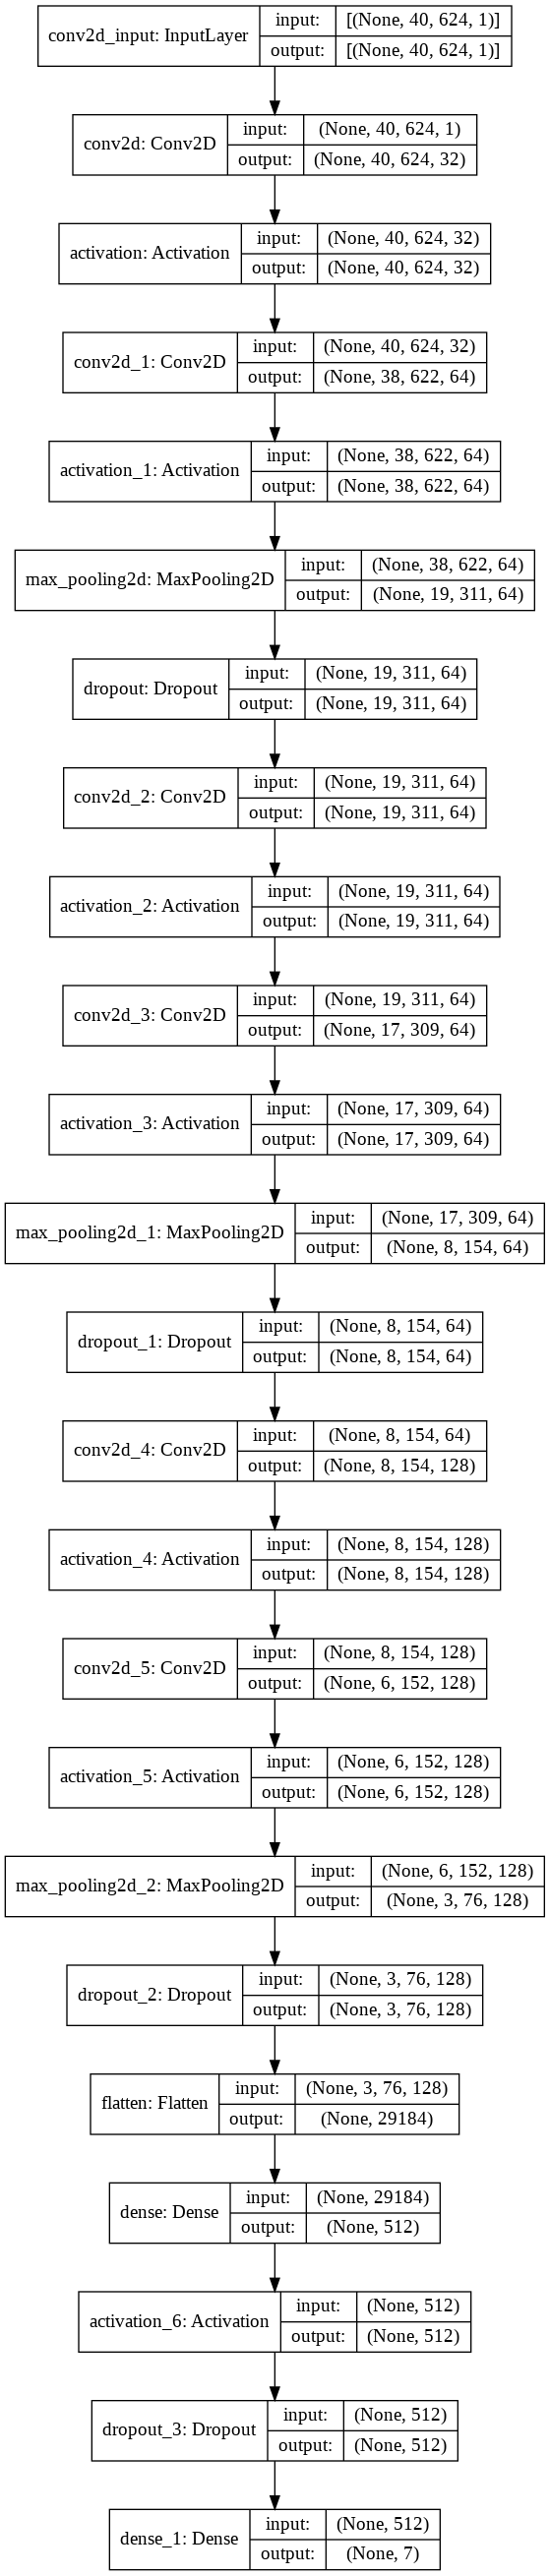

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='audio_model0_US_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!mkdir "/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v3/"

In [ ]:
chkpoint_filepath="/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v3/"
csv_log_file='/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v3/train_P4v3_audio.log'


# history,model=compile_and_fit(audio_model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)


logdir = chkpoint_filepath + datetime.now().strftime("%Y%m%d-%H%M%S")

if not os.path.exists(logdir):
    os.mkdir(logdir)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# filepath="/content/gdrive/My Drive/TFM_MUSI/FACES6/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
chkpoint_filepath=chkpoint_filepath+":{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(chkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
csv_logger = CSVLogger(csv_log_file)

callbacks_list = [checkpoint,csv_logger]
# history=model.fit(xtrain, Y_train,
#                   epochs=epochs,
#                   validation_data=(xtest, Y_test),
#                   batch_size=batch_size,
#                   callbacks=callbacks_list)

history=model.fit(xtrain, y_train_new,
                  epochs=epochs,
                  validation_data=(xtest, y_test_new),
                  batch_size=batch_size,
                  callbacks=callbacks_list)


model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v3/Fayek_spec.h5")


NameError: ignored

In [ ]:
save_plot(history,"P4v3 Fayek spec no normalized",filename="/content/gdrive/My Drive/TFM_MUSI/Audio/Results")


In [ ]:
testx=asarray(x_data_test)
TestX=tf.expand_dims(testx, axis=-1)
y_test=[ emo_dict[get_emo_from_categorical(test_data[label])] for label in test_data.keys()]
# y_test

In [ ]:
def evaluate_model(model):
  predictions=model.predict(TestX)
  print('Confusion Matrix')
  ypred=[round(list(i).index(max(i))) for i in predictions]
  print(ypred)
  print(confusion_matrix(y_test, ypred))
  # print(confusion_matrix(y_test, ypred))

evaluate_model(model)

In [ ]:
print(emo_dict)

In [ ]:
for emo in emo_dict.keys():
  print("emotion: ", emo)
  print("number of audios: ",list(dict_xy_afew.values()).count(emo))
  print("-----")

In [ ]:
###############################################################

In [ ]:
# prova restant la mitjana

normalize=True # alerta amb Nans
preemphasis=True
desired_audio_len=137063 #maximum len
num_classes=7

train_data={}
test_data={}

x_data_train,y_data_train = create_set(urls_afew_train, train_data, desired_audio_len ,normalize,preemphasis)
x_data_test,y_data_test = create_set(urls_afew_test,    test_data, desired_audio_len, normalize,preemphasis)

In [ ]:
x_data_train[-1]

In [ ]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(x_data_train,y_data_train)
x_test,y_test=shuffle(x_data_test,y_data_test)

In [ ]:
print(asarray(x_train).shape)
print(asarray(x_data_train).shape)
x_train[-1]

In [ ]:
#PARAMS:
DROPOUT=0.5
l2_regul=0.01
N_OUTPUT_LABELS=7
input_shape=asarray(x_data_train[0]).shape
input_shape=list(input_shape)
input_shape.append(1)
input_shape
epochs=50
batch_size=16
lr=0.0001

In [ ]:
def Classifier():
    model = Sequential()

    model.add(Conv2D(filters=16,
                     kernel_size=(10, 10),
                     strides=1,
                     activation='relu',
                     input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_regul)))
    
    model.add(BatchNormalization())

    model.add(Conv2D(filters=16,
                     kernel_size=(10, 10),
                     strides=1,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_regul)))
    
    model.add(BatchNormalization())

    #Afegit això:
    # model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    
    model.add(Dense(units=716,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='softmax'))
    
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dense(units=N_OUTPUT_LABELS,
                    activation='softmax'))
    return model


audio_model = Classifier()


In [ ]:
def compile_and_fit(model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=0.001):
  optimizer = tf.keras.optimizers.RMSprop(lr=lr)
  model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
  
  logdir = chkpoint_filepath + datetime.now().strftime("%Y%m%d-%H%M%S")
  
  if not os.path.exists(logdir):
      os.mkdir(logdir)
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
  
  # filepath="/content/gdrive/My Drive/TFM_MUSI/FACES6/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
  chkpoint_filepath=chkpoint_filepath+":{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
  checkpoint = ModelCheckpoint(chkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  
  # csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
  csv_logger = CSVLogger(csv_log_file)
  E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0,
                                            patience=35,
                                            verbose=1,
                                            mode="auto",
                                            restore_best_weights=False)
  callbacks_list=[E_stopping]

  # callbacks_list = [checkpoint,csv_logger]
  history=model.fit(xtrain, Y_train,
                   epochs=epochs,
                   validation_data=(xtest, Y_test),
                   batch_size=batch_size,
                   callbacks=callbacks_list)

  return history,model


In [ ]:
def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy "+title)

  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.show()
  

Epoch 1/50
49/49 [==============================] - 5s 70ms/step - loss: 1.9594 - categorical_accuracy: 0.1860 - accuracy: 0.1860 - val_loss: 1.9364 - val_categorical_accuracy: 0.2021 - val_accuracy: 0.2021
Epoch 2/50
49/49 [==============================] - 3s 52ms/step - loss: 1.9030 - categorical_accuracy: 0.2198 - accuracy: 0.2198 - val_loss: 1.9293 - val_categorical_accuracy: 0.2021 - val_accuracy: 0.2021
Epoch 3/50
49/49 [==============================] - 3s 52ms/step - loss: 1.8883 - categorical_accuracy: 0.2207 - accuracy: 0.2207 - val_loss: 1.9310 - val_categorical_accuracy: 0.2283 - val_accuracy: 0.2283
Epoch 4/50
49/49 [==============================] - 3s 52ms/step - loss: 1.8665 - categorical_accuracy: 0.2629 - accuracy: 0.2629 - val_loss: 1.9211 - val_categorical_accuracy: 0.1916 - val_accuracy: 0.1916
Epoch 5/50
49/49 [==============================] - 3s 52ms/step - loss: 1.8664 - categorical_accuracy: 0.2724 - accuracy: 0.2724 - val_loss: 1.9287 - val_categorical_accur

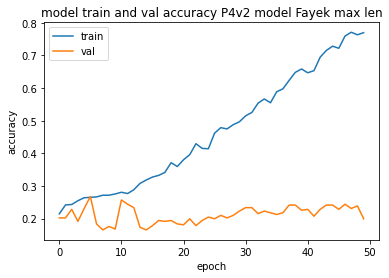

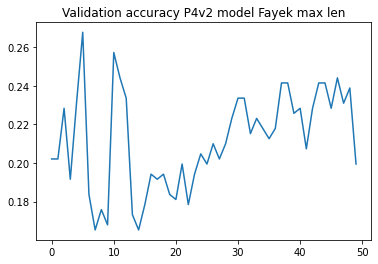

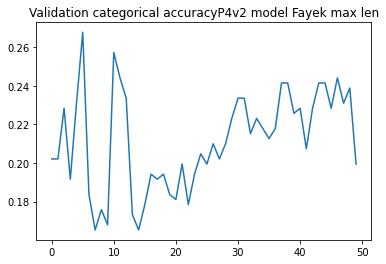

In [ ]:
#Test 1: Longitud de los audios= la longitud del audio más corto
# Sin pre-emphasis
# normalizado


# chkpoint_filepath="/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/"
# csv_log_file='/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/train_P4v2_audio.log'

# X_train=asarray(x_train)
# Y_train=asarray(y_train)
# X_test=asarray(x_test)
# Y_test=asarray(y_test)
# xtrain = tf.expand_dims(X_train, axis=-1)
# xtest= tf.expand_dims(X_test, axis=-1)


# audio_model = Classifier()
history,model=compile_and_fit(model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)
model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/Fayek_spec_norm.h5")
plot_model(history,"P4v2 model Fayek max len")

In [ ]:
#Test amb el model de l'urbandsound
model=model2()
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
history,model=compile_and_fit(model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)
model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/US_spec_norm.h5")
plot_model(history,"P4v2 model US max len norm")

In [ ]:
# prova restant la mitjana

normalize=True # normalitzat normal
preemphasis=True
desired_audio_len=137063 #maximum len
num_classes=7

train_data={}
test_data={}

x_data_train,y_data_train = create_set(urls_afew_train, train_data, desired_audio_len ,normalize,preemphasis)
x_data_test,y_data_test = create_set(urls_afew_test,    test_data, desired_audio_len, normalize,preemphasis)

In [ ]:
x_data_train[-1]

In [ ]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(x_data_train,y_data_train)
x_test,y_test=shuffle(x_data_test,y_data_test)

In [ ]:
print(asarray(x_train).shape)
print(asarray(x_data_train).shape)
x_train[-1]

In [ ]:
#PARAMS:
DROPOUT=0.5
l2_regul=0.01
N_OUTPUT_LABELS=7
input_shape=asarray(x_data_train[0]).shape
input_shape=list(input_shape)
input_shape.append(1)
input_shape
epochs=50
batch_size=16
lr=0.0001

In [ ]:
audio_model = Classifier()

In [ ]:
#Test 1: Longitud de los audios= la longitud del audio más corto
# Sin pre-emphasis
# normalizado


chkpoint_filepath="/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/"
csv_log_file='/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/train_P4v2_audio.log'

X_train=asarray(x_train)
Y_train=asarray(y_train)
X_test=asarray(x_test)
Y_test=asarray(y_test)
xtrain = tf.expand_dims(X_train, axis=-1)
xtest= tf.expand_dims(X_test, axis=-1)


audio_model = Classifier()
history,model=compile_and_fit(audio_model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)
model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/Fayek_spec_norm.h5")
plot_model(history,"P4v2 model Fayek max len")